# 🛒 Online Retail (UCI) — Customer Segmentation Project

The Online Retail dataset contains all transactions from a UK-based e‑commerce store between 2010 and 2011.  
It includes product information, quantities, prices, timestamps, and customer identifiers.

### 🎯 Business Context
E‑commerce companies rely heavily on customer understanding to optimize marketing, retention, and product strategy.  
However, raw transactional data is often noisy: cancellations, missing IDs, inconsistent product codes, and pricing anomalies can distort insights.

To build reliable customer segments, we must first create a **clean, trustworthy dataset**.

### 🧠 Objective of This Notebook
This notebook focuses on **data exploration and data cleaning**.  
The goal is to transform the raw dataset into a structured, consistent version suitable for:

- RFM analysis (Recency, Frequency, Monetary)
- Customer segmentation using clustering
- Business insights and actionable recommendations

### 📦 Deliverables from This Notebook
- `data_raw.csv` → original dataset  
- `data_cleaned.csv` → cleaned dataset (no cancellations, no anomalies, no missing IDs)  
- `data_canceled.csv` → all canceled transactions  

The next notebook will build on this cleaned dataset to perform **RFM segmentation and clustering**.

# 📚 1 - Libraries

In [28]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date handling
from datetime import datetime

# Clustering (used later in the project)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ⚙️ 2 - Load raw data :

The dataset was downloaded from Kaggle and saved locally as `data_raw.csv`.


In [29]:
# Load dataset - https://www.kaggle.com/datasets/carrie1/ecommerce-data
data_raw = pd.read_csv('data_raw.csv',encoding='ISO-8859-1')

# Preview
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 🫧 3 - Cleaning


In [30]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 🔍 Initial Observations
- `CustomerID` contains many missing values  
- `InvoiceDate` is stored as an object → must be converted to datetime  
- `StockCode` contains product codes, special codes, and non-product entries  
- Negative quantities correspond to cancellations  
- Some `UnitPrice` values are equal to 0 → invalid  

## 3.1 - Convert Types & Remove Missing CustomerID

In [31]:
# Remove rows without CustomerID
df = data_raw.dropna(subset=['CustomerID']).copy()

# Convert CustomerID to integer (but keep as object for grouping)
df['CustomerID'] = df['CustomerID'].astype('int').astype('object')

# Convert InvoiceData to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reset index
df.reset_index(drop=True, inplace=True)

data = df.copy()

## 3.2 - Clean StockCode & Description

StockCode contains:
- numeric product codes  
- numeric codes with letters (variants, e.g., color)  
- letter-only codes (non-product items: shipping, samples, discounts)

We only want **real products**, not operational codes.

In [32]:
data['StockCode'].unique().shape
data['StockCode'].unique()[:50]

array(['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730',
       '22633', '22632', '84879', '22745', '22748', '22749', '22310',
       '84969', '22623', '22622', '21754', '21755', '21777', '48187',
       '22960', '22913', '22912', '22914', '21756', '22728', '22727',
       '22726', '21724', '21883', '10002', '21791', '21035', '22326',
       '22629', '22659', '22631', '22661', '21731', '22900', '21913',
       '22540', '22544', '22492', 'POST', '22086', '20679', '37370',
       '21871'], dtype=object)

### Letter-only codes

In [33]:
# Identify letter-only codes
data[data['StockCode'].str.contains(r'^[A-Za-z].*', na=False)][['StockCode','Description']].drop_duplicates()

# Remove them
data = data[~data['StockCode'].str.contains(r'^[A-Za-z].*', na=False)]

-> Letter-only StockCodes correspond to **non-product operations**  
(e.g., shipping fees, manual adjustments, samples).  
We **remove them** to focus on actual customer purchases.

### Numeric + Letter suffix

In [34]:
# Numeric + Letter suffix
data[data['StockCode'].str.contains(r'\d+[A-Za-z]$', na=False)][['StockCode','Description']].drop_duplicates().head(10)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
60,82494L,WOODEN FRAME ANTIQUE WHITE
87,85099C,JUMBO BAG BAROQUE BLACK WHITE
90,84997B,RED 3 PIECE RETROSPOT CUTLERY SET
91,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET
100,84519A,TOMATO CHARLIE+LOLA COASTER SET
101,85183B,CHARLIE & LOLA WASTEPAPER BIN FLORA


-> These represent **variants of the same product** (e.g., color, packaging).  
We **keep them**.


### Numeric-only codes

In [35]:
# Numeric-only StockCode
data[data['StockCode'].str.isdigit()][['StockCode','Description']].drop_duplicates().head(10)

,StockCode,Description
1,71053,WHITE METAL LANTERN
5,22752,SET 7 BABUSHKA NESTING BOXES
6,21730,GLASS STAR FROSTED T-LIGHT HOLDER
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT
10,22745,POPPY'S PLAYHOUSE BEDROOM
11,22748,POPPY'S PLAYHOUSE KITCHEN
12,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL
13,22310,IVORY KNITTED MUG COSY


-> These are **standard product** codes.  
We **keep them**.


## 3.3 - Clean UnitPrice

- Some products have a **price of 0**, which is invalid.
- These rows are removed.

In [36]:
# UnitPrice = 0
data['UnitPrice'].value_counts().sort_index()
data[data['UnitPrice']==0].sort_values(by="CustomerID").head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
327463,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia
140517,554037,22619,SET OF 6 SOLDIER SKITTLES,80,2011-05-20 14:13:00,0.0,12415,Australia
329894,574469,22385,JUMBO BAG SPACEBOY DESIGN,12,2011-11-04 11:55:00,0.0,12431,Australia
362308,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2011-11-18 13:23:00,0.0,12444,Norway
109968,550188,22636,CHILDS BREAKFAST SET CIRCUS PARADE,1,2011-04-14 18:57:00,0.0,12457,Switzerland


In [37]:
# Remove rows with UnitPrice = 0
data = data[data['UnitPrice'] > 0]

## 3.4 - Handle cancellations

### Understanding Cancellations
- Negative quantities represent **canceled items**.
- Canceled invoices always start with **"C"**.
- We must match each cancellation with its original purchase.


### Quantity distribution

In [38]:
data['Quantity'].describe()

,Quantity
count,404876.000000
mean,12.072511
std,248.467980
min,-80995.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,80995.000000


### Verify cancellation logic

In [39]:
# Negative quantities always correspond to InvoiceNo starting with 'C'
(~data[data['Quantity'] < 0]['InvoiceNo'].str.startswith('C')).sum()

# No positive quantity in invoices starting with 'C'
data[data['InvoiceNo'].str.startswith('C')]['Quantity'].sort_values(ascending=False).head()

,Quantity
1440,-1
406636,-1
154,-1
405139,-1
1444,-1


### Robust Cancellation Matching (Fabien Daniel method)

This code and method can be found here : https://www.kaggle.com/code/fabiendaniel/customer-segmentation#2.-Exploring-the-content-of-variables

In [40]:
doubtfull_entry = []
entry_to_remove = []

df_cleaned = data.copy()
df_cleaned['QuantityCanceled'] = 0

for index, col in data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue

    df_test = data[
        (data['CustomerID'] == col['CustomerID']) &
        (data['StockCode'] == col['StockCode']) &
        (data['InvoiceDate'] < col['InvoiceDate']) &
        (data['Quantity'] > 0)
    ].copy()

    # No matching order
    if df_test.shape[0] == 0:
        doubtfull_entry.append(index)

    # Exactly one matching order
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)

    # Multiple matches → take the most recent valid one
    else:
        df_test.sort_index(ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

### Cancellation Handling — Summary
- We match each negative quantity with its original purchase.
- If matched → we adjust the original quantity.
- If unmatched → flagged as doubtful.


## 🧹 Cleaning Summary
- Removed missing CustomerID  
- Removed non-product StockCodes  
- Removed UnitPrice = 0  
- Matched cancellations  
- Created data_cleaned and data_canceled  


# 🗂️ 4 - Create data_cleaned + data_canceled

We create two distinct datasets :
- **data_cleaned** all the valid purchases.
- **data_cancelled** containing all the rows associated with cancellation.


In [41]:
# Final datasets
data_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['QuantityCanceled'] == 0)]
data_canceled = df_cleaned[(df_cleaned['Quantity'] < 0) | (df_cleaned['QuantityCanceled'] > 0)]

data_canceled.reset_index(drop=True, inplace=True)
data_cleaned.reset_index(drop=True, inplace=True)

# 📊 5 - Exploratory Data Analysis (EDA)

This section explores the cleaned Online Retail dataset to understand customer behavior, product performance, and sales dynamics.  
The insights extracted here will guide the next steps: **RFM feature engineering and customer segmentation**.

In [46]:
# Work on data cleaned
data = data_cleaned.copy()

# Create line-level revenue
data["Price_Line"] = data["Quantity"] * data["UnitPrice"]

### 5.1 - Global Exploration

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389207 entries, 0 to 389206
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         389207 non-null  object        
 1   StockCode         389207 non-null  object        
 2   Description       389207 non-null  object        
 3   Quantity          389207 non-null  int64         
 4   InvoiceDate       389207 non-null  datetime64[ns]
 5   UnitPrice         389207 non-null  float64       
 6   CustomerID        389207 non-null  object        
 7   Country           389207 non-null  object        
 8   QuantityCanceled  389207 non-null  int64         
 9   Price_Line        389207 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 29.7+ MB


In [43]:
print("Dataset size:", data.shape)
print("Number of customers:", data['CustomerID'].nunique())
print("Number of product IDs:", data['StockCode'].nunique())
print("Number of product descriptions:", data['Description'].nunique())
print("Number of transactions:", data['InvoiceNo'].nunique())
print("Number of countries:", data['Country'].nunique())
print("Date range:", data['InvoiceDate'].min(), "→", data['InvoiceDate'].max())

Dataset size: (389207, 10)
Number of customers: 4319
Number of product IDs: 3643
Number of product descriptions: 3849
Number of transactions: 18234
Number of countries: 37
Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00


#### 🔍 Key Observations
- The dataset contains **high product diversity**.
- Customers span multiple countries, but the UK dominates.
- The time range covers **Dec 2010 → Dec 2011**.
- Revenue must be analyzed at multiple levels: line, basket, customer.


### 5.2 - Basket-Level

In [44]:
df_basket = data.groupby(['CustomerID','InvoiceNo'], as_index=False).agg(
    Total_Quantity=('Quantity','sum'),
    N_Product=('StockCode','count'),
    Basket_Value=('Price_Line','sum')
)

print("Average basket value: {:.2f}".format(df_basket['Basket_Value'].mean()))
print("Avg number of transactions per customer: {:.2f}".format(df_basket.groupby('CustomerID')['InvoiceNo'].nunique().mean()))
print("Avg number of product types per transaction: {:.2f}".format(df_basket['N_Product'].mean()))
print("Avg quantity per transaction: {:.2f}".format(df_basket['Total_Quantity'].mean()))

Average basket value: 445.52
Avg number of transactions per customer: 4.22
Avg number of product types per transaction: 21.35
Avg quantity per transaction: 265.13


### 5.3 - Visualizations  

#### Top 10 Products by Quantity

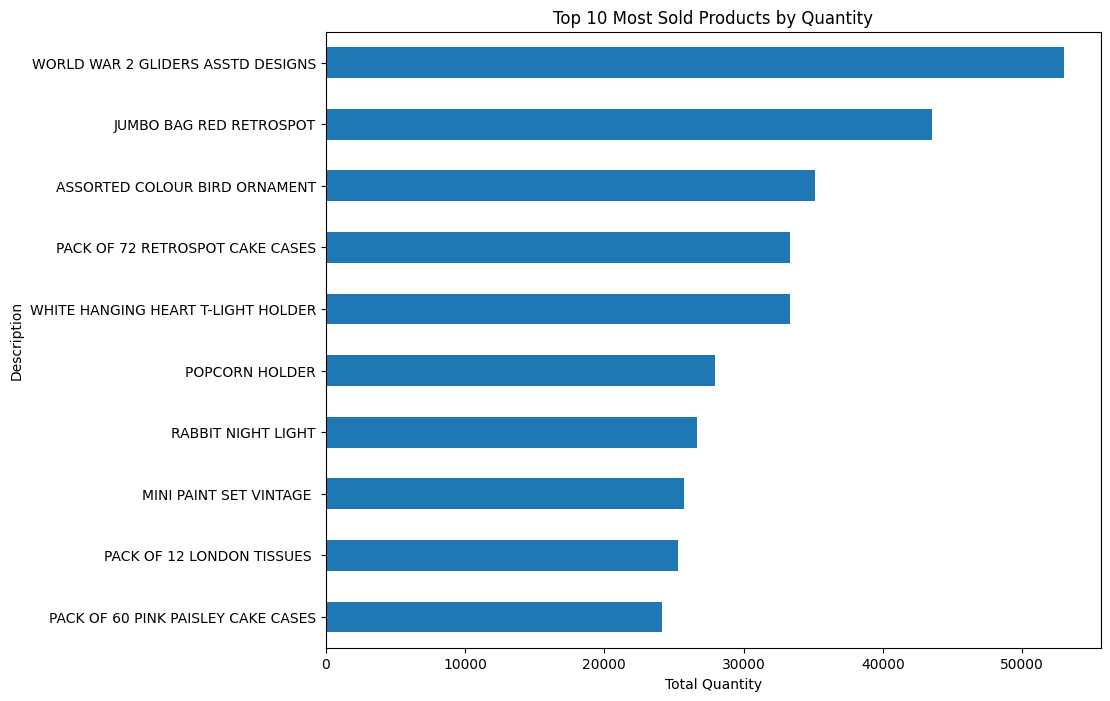

In [89]:
plt.figure(figsize=(10,8))
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Most Sold Products by Quantity")
plt.xlabel("Total Quantity")
plt.gca().invert_yaxis()
plt.show()

#### Top 10 products by revenue

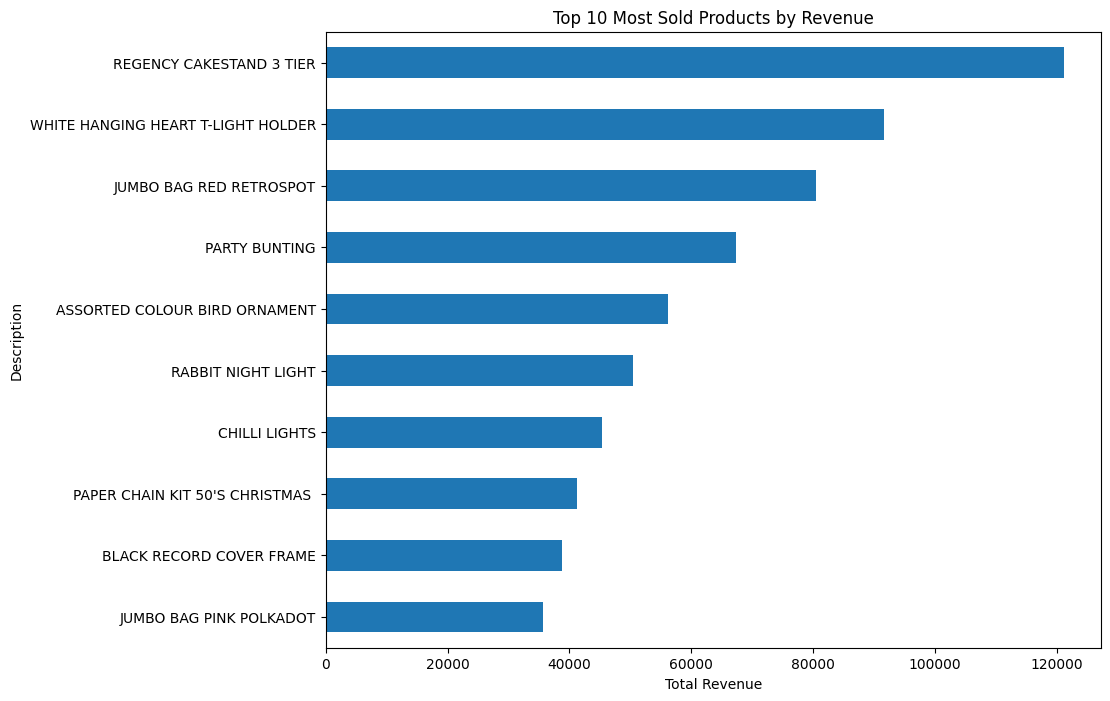

In [88]:
plt.figure(figsize=(10,8))
data.groupby('Description')['Price_Line'].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Most Sold Products by Revenue")
plt.xlabel("Total Revenue")
plt.gca().invert_yaxis()
plt.show()

#### Top 10 Countries

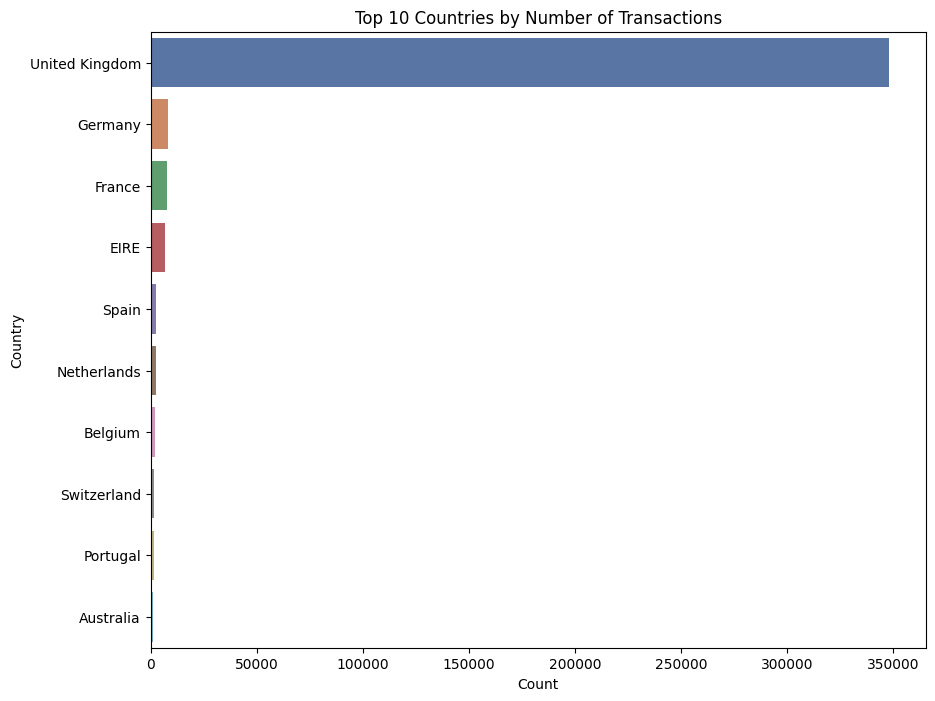

In [60]:
plt.figure(figsize=(10,8))
top_countries = data['Country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index,
            hue=top_countries.index,
            palette="deep", legend=False)
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Count")
plt.show()

#### Quantity Distribution (truncated)

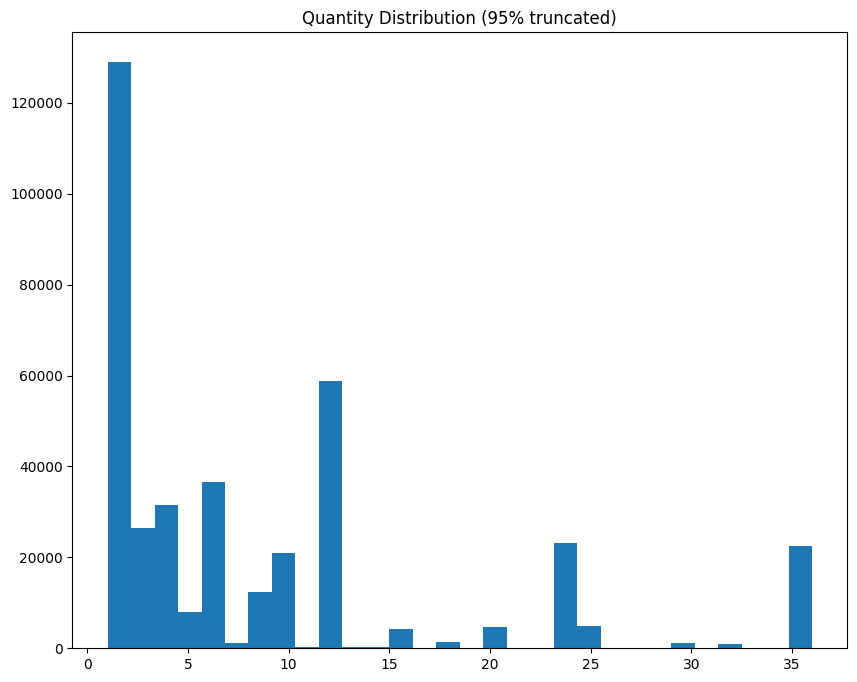

In [82]:
cop = data['Quantity'].clip(upper=data['Quantity'].quantile(0.95))

plt.figure(figsize=(10,8))
plt.hist(cop, bins=30)
plt.title("Quantity Distribution (95% truncated)")
plt.show()

#### UnitPrice Distribution (truncated)

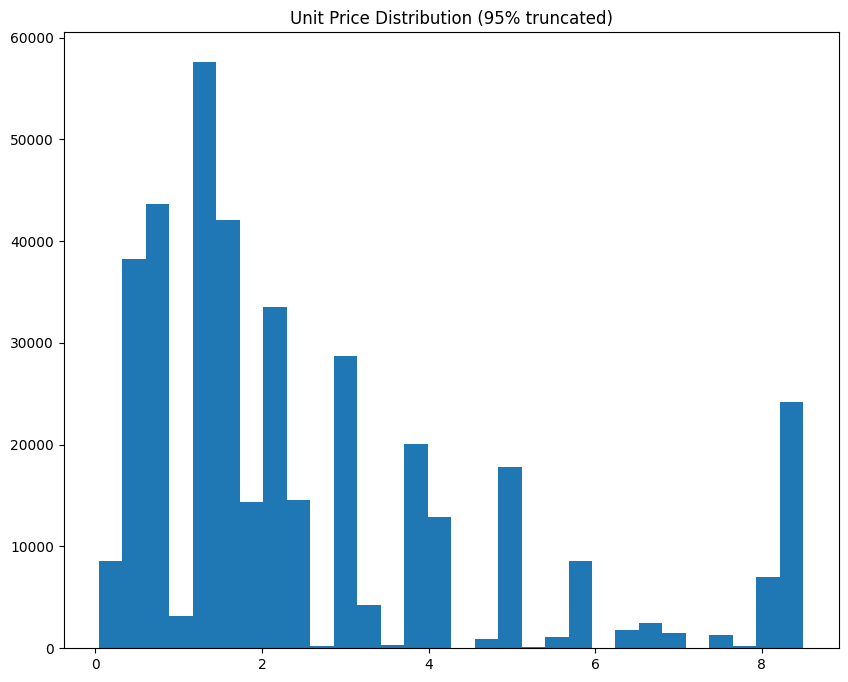

In [91]:
cop = data['UnitPrice'].clip(upper=data['UnitPrice'].quantile(0.95))

plt.figure(figsize=(10,8))
plt.hist(cop,bins=30)
plt.title("Unit Price Distribution (95% truncated)")

plt.show()

#### Time Analysis (Year, Month, Day, Hour of day)

##### Revenue by Year

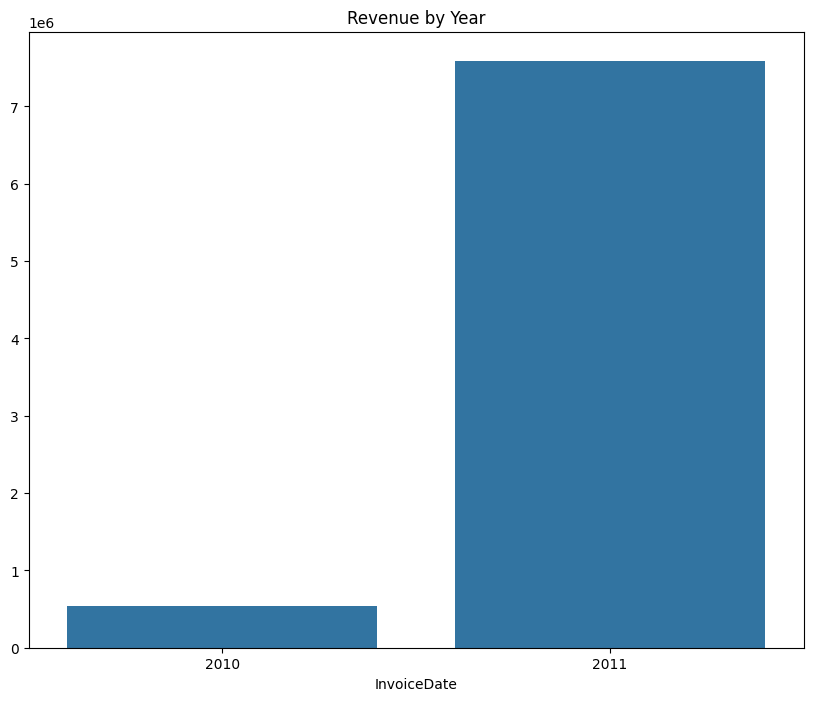

In [72]:
plt.figure(figsize=(10,8))
yearly = data.groupby(data['InvoiceDate'].dt.year)['Price_Line'].sum()
sns.barplot(x=yearly.index.astype(str), y=yearly.values)
plt.title("Revenue by Year")
plt.show()

##### Revenue by Month

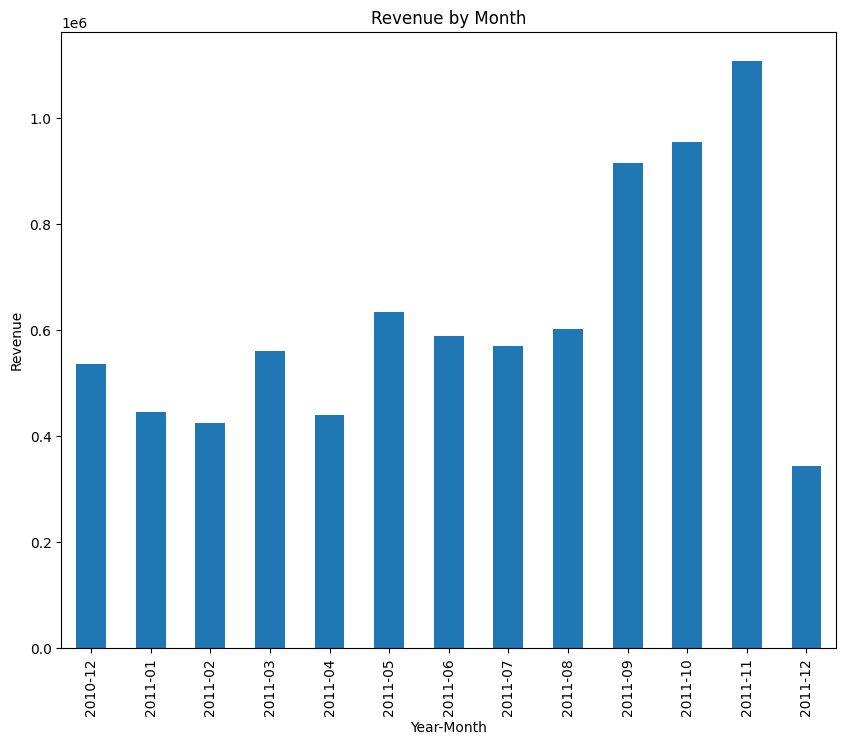

In [79]:
data["YearMonth"]= data["InvoiceDate"].dt.to_period("M")

monthly = data.groupby("YearMonth")['Price_Line'].sum()

plt.figure(figsize=(10,8))
monthly.plot(kind='bar')
plt.title("Revenue by Month")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.show()

##### Revenue by Day

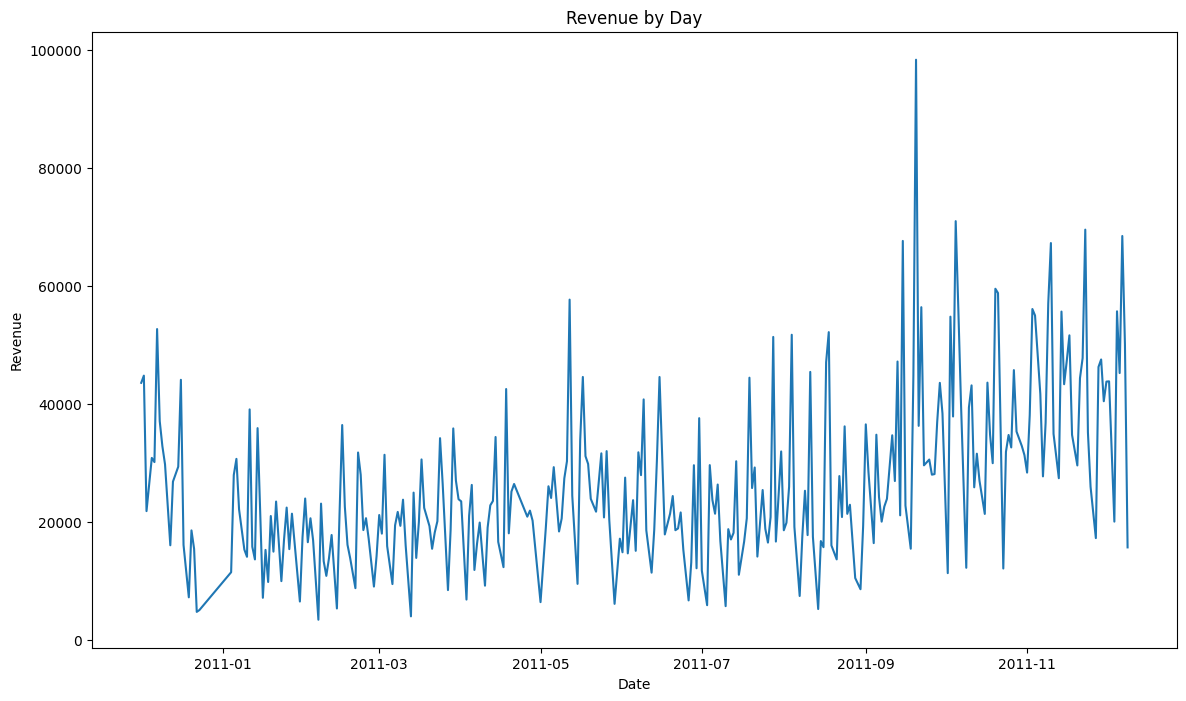

In [81]:
daily = data.groupby(data['InvoiceDate'].dt.date)['Price_Line'].sum()

plt.figure(figsize=(14,8))
plt.plot(daily.index, daily.values)
plt.title("Revenue by Day")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

##### Revenue by hour of day


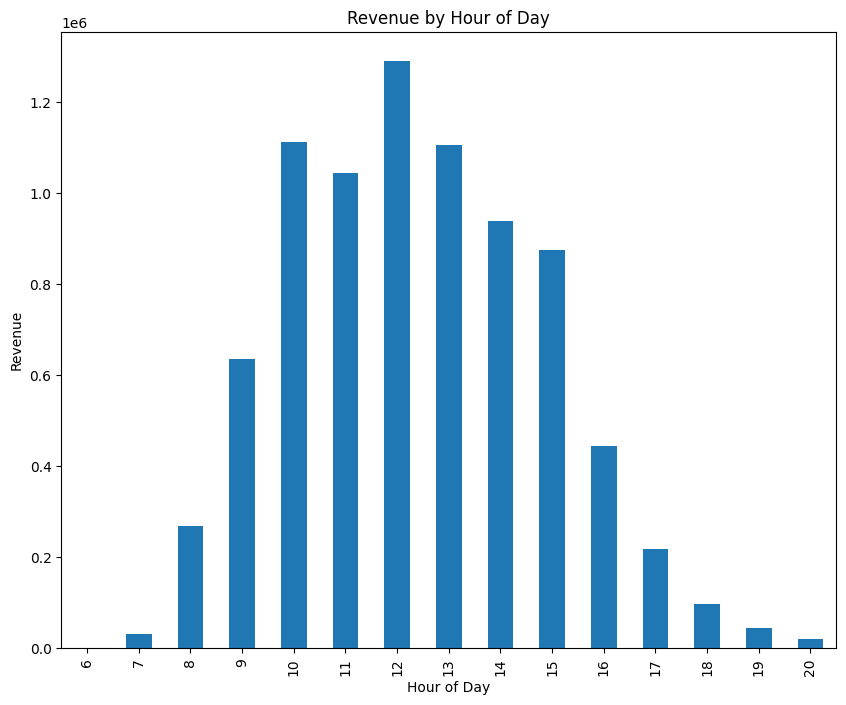

In [90]:
hourly = data.groupby(data['InvoiceDate'].dt.hour)['Price_Line'].sum()

plt.figure(figsize=(10,8))
hourly.plot(kind='bar')
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.show()

# 📁 6 - Export datasets

In [84]:
data_cleaned.to_csv("data_cleaned.csv", index=False)
data_canceled.to_csv("data_canceled.csv", index=False)

print("Datasets exported successfully:")
print(f"- data_cleaned: {data_cleaned.shape}")
print(f"- data_canceled: {data_canceled.shape}")

Datasets exported successfully:
- data_cleaned: (389207, 9)
- data_canceled: (15669, 9)


# 📌 7 - Conclusion

The dataset shows:
- Strong seasonality and daily fluctuations in revenue  
- A small number of products dominating sales  
- A highly skewed distribution of quantities and prices  
- UK as the primary market  
- Significant variability in basket size and value  

These insights confirm the relevance of **RFM segmentation** to identify customer groups based on:
- Recency  
- Frequency  
- Monetary value  

The next step is to compute RFM features and perform clustering.

### Limitations
- The dataset covers only one year of activity  
- No customer demographic information is available  
- Product hierarchy (categories) is missing  
